# Customer Churn Prediction & Business Insights

End-to-end data science project focused on predicting customer churn, extracting actionable business insights, and delivering a Power BI–ready dataset.

Author: Yochabel Martínez Cázares

Date: 02/02/2026

### <span style="color:red">1. Business Problem & Target Definition</span>

#### <span style="color:#1E90FF">Business Problem</span>
Subscription platforms face significant losses when customers cancel their service (churn). Retaining an existing customer is usually more profitable than acquiring a new one, so identifying which customers are at risk of churn is a strategic business priority.

#### <span style="color:#1E90FF">Problem Statement</span>
Predict the probability of customer churn to enable proactive retention actions, optimizing resources and reducing revenue loss.

#### <span style="color:#1E90FF">Target Definition</span>
The target variable of the model is Churn Value, defined as:
- **0** → The customer did not cancel the service
- **1** → The customer canceled the service (churn)

The problem is formulated using **binary classification**, where the model estimates the probability that a customer will leave the platform in the near future.

#### <span style="color:#1E90FF">Business Objective</span>
- Identify high-risk customers
- Prioritize retention actions
- Support business decisions with interpretable metrics
- Integrate results into an executive dashboard in Power BI

In this way, the model directly connects data analysis with real business impact.

### <span style="color:red">2. Data Loading & Initial Exploration</span>

This dataset represents a subscription-based digital platform where each row corresponds to a user.
The objective is to explore the structure, quality, and initial characteristics of the data before performing any cleaning or transformations.

In [229]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [244]:
#Read Dataset
df = pd.read_excel("data/Telco_Customer_Churn.xlsx")

#Dataset details
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### <span style="color:red">3. Data Cleaning & Missing Values Treatment</span>

Data type adjustments, missing value handling, and consistency validation are performed. Transformations focus on preserving business-relevant information, preventing data leakage, and maintaining variable interpretability.

Columns not needed in the project:
- CustomerID
- Country
- State
- City
- Zip Code
- Lat Long
- Latitude
- Longitude
- Count
- Churn Label
- Churn Score
- Churn Reason

In [231]:
cols_to_drop = ["CustomerID","Count","Country","State","City","Zip Code","Lat Long","Latitude","Longitude","Churn Label","Churn Score","Churn Reason"]
df = df.drop(columns=cols_to_drop)

Value counts of the target variable 'Churn':


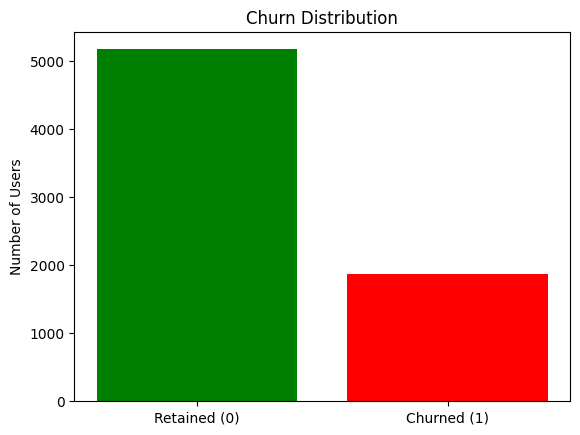

In [232]:
print("Value counts of the target variable 'Churn':")
churn_counts = df["Churn Value"].value_counts()
#Bar plot
plt.figure()
plt.bar(churn_counts.index, churn_counts.values, color=["green", "red"])
plt.title("Churn Distribution")
plt.ylabel("Number of Users")
plt.xticks(churn_counts.index, ["Retained (0)", "Churned (1)"])
plt.show()

In [233]:
#Identify missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64


In [234]:
#Convert 'Total Charges' from string to numeric and handle missing values for new users
#Missing values correspond to new customers with no accumulated charges
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce").fillna(0)

print("\nMissing values after:")
print(df.isnull().sum())


Missing values after:
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64


### <span style="color:red">4. Feature Engineering for Churn</span>

"is_monthly_contract" is a binary flag created to explicitly capture users on month-to-month subscriptions, which typically present higher churn risk due to lower commitment.
Additionally,"avg_monthly_spend" was calculated by normalizing total charges by tenure, providing a more comparable measure of user spending behavior across customers with different subscription lengths. These features improve model interpretability and help capture key behavioral patterns related to churn.

In [235]:
#Flag for monthly subscriptions (higher churn risk)
df["is_monthly_contract"] = (df["Contract"] == "Month-to-month").astype(int)
#Average monthly spend over the user's lifetime
df["avg_monthly_spend"] = np.where(df["Tenure Months"] > 0,df["Total Charges"] / df["Tenure Months"],0)

### <span style="color:red">5. Exploratory Data Analysis</span>

The key variables of the dataset are analyzed to understand their distribution and relationship to churn. Churn patterns are explored based on variables such as customer tenure, monthly charges, contract type, and contracted services.

EDA allows for the identification of relevant trends, the validation of business assumptions, and the development of features that better capture customer behavior.

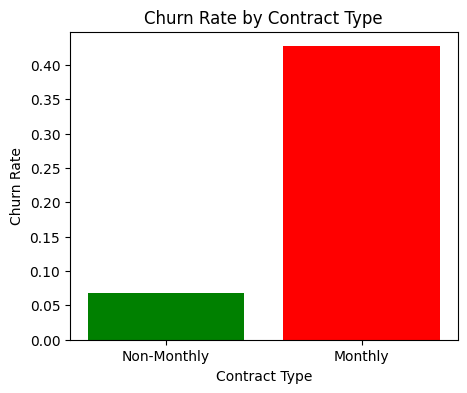

In [236]:
#Calculate churn rate by contract type
churn_by_contract = (df.groupby("is_monthly_contract")["Churn Value"].mean())

#Plot churn rate by contract type
plt.figure(figsize=(5,4))
plt.bar(churn_by_contract.index, churn_by_contract.values, color=["green", "red"])
plt.xticks(churn_by_contract.index,["Non-Monthly", "Monthly"])
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.xlabel("Contract Type")
plt.show()

### <span style="color:red">6. Model Training</span>

A logistic regression model is trained using a pipeline that integrates preprocessing of numerical and categorical variables using ColumnTransformer.
This approach allows for a clean and consistent flow from raw data to predictions, prioritizing interpretability and ease of business explanation.

In [237]:
#Variables selection
X = df.drop(columns=["Churn Value"]) #Independent variables
y = df["Churn Value"] #Target variable
#Train/test = 80%/20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#Identify categorical (text) columns
categorical_cols = X_train.select_dtypes(include="object").columns
#Identify numeric columns
numeric_cols = X_train.select_dtypes(exclude="object").columns

#Create the preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    #Transformation for numerical variables
    #StandardScaler: (mean 0, standard deviation 1)
    ("numeric", StandardScaler(), numeric_cols),
    #Transformation for categorical variables
    #OneHotEncoder: converts categories into binary features (0/1)
    #drop="first" Avoids multicollinearity in logistic regression
    #handle_unknown="ignore" prevents errors when an unseen categorie appears
    ("categoric", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)])

#Create the full pipeline
#Combines data preprocessing and logistic regression model training
clf = Pipeline(steps=[("preprocessing", preprocessor),("model", LogisticRegression(max_iter=1000, class_weight="balanced"))])
#Train the complete pipeline
clf.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### <span style="color:red">7. Model Evaluation</span>
The model is evaluated using metrics such as the classification report, ROC, AUC, confusion matrix, and precision-recall curve.
The analysis focuses particularly on the churn class, evaluating the trade-off between recall and precision. Detecting at-risk customers is prioritized, as losing a customer has a greater impact than contacting one who ultimately doesn't churn.

In [238]:
#Predict the final class (0: no churn, 1: churn)
y_pred = clf.predict(X_test)
#Predict churn probability
y_pred_proba = clf.predict_proba(X_test)[:, 1]
#Classification report
print(classification_report(y_test, y_pred))
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC AUC: 0.8489188560799814


*The model achieves a recall of approximately 0.78 for the churn class and an ROC AUC of 0.85, indicating good discrimination between churn and retained customers.*

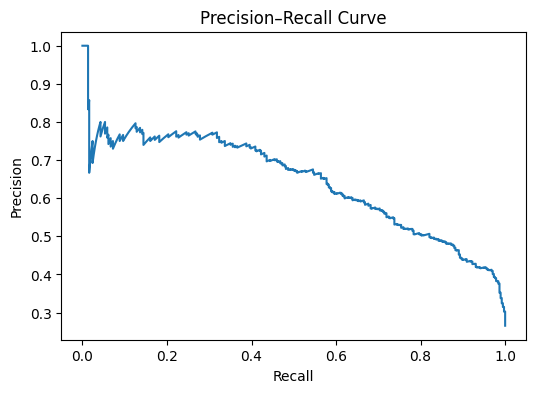

In [239]:
#Compute precision, recall, and decision thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#Plot Precision–Recall curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall") #(Churn)
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

*The Precision-Recall curve shows a suitable trade-off for retention strategies, maintaining high recall for the churn class at the cost of a gradual decrease in precision, which is acceptable from a business perspective.*

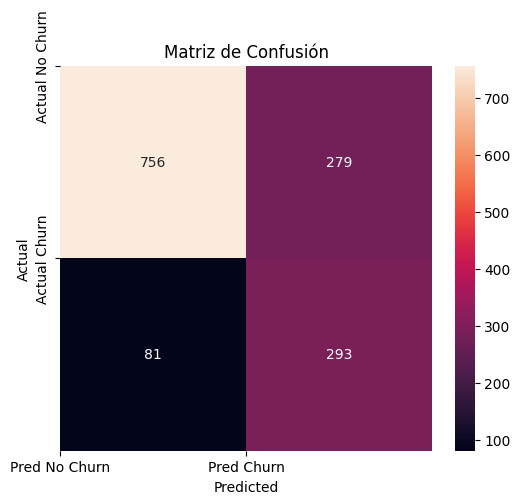

In [240]:
#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#Plot confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="rocket")
plt.xticks([0,1], ["Pred No Churn", "Pred Churn"])
plt.yticks([0,1], ["Actual No Churn", "Actual Churn"])
plt.title('Matriz de Confusión')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

*The confusion matrix indicates that the model correctly identifies most churn customers, prioritizing churn detection and reducing the number of customers lost without intervention.*

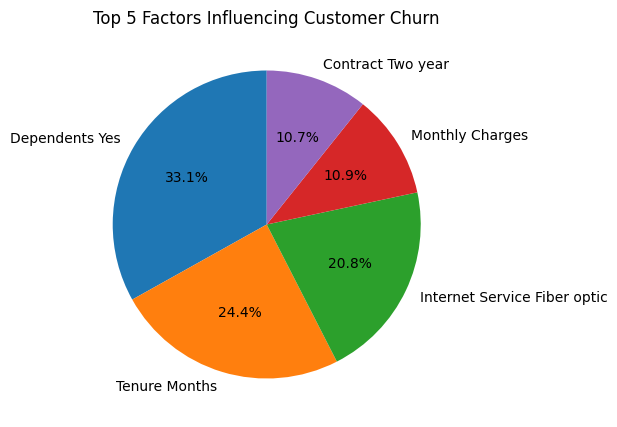

In [241]:
#Create a simple dataframe with feature importance
coef_df = pd.DataFrame({"feature": clf.named_steps["preprocessing"].get_feature_names_out(),"importance": np.abs(clf.named_steps["model"].coef_[0])})
#Clear names for readability
coef_df["feature"] = (coef_df["feature"].str.replace("numeric__", "", regex=False).str.replace("categoric__", "", regex=False).str.replace("_", " "))
#Select top 5 most important features
top5 = coef_df.sort_values(by="importance", ascending=False).head(5)

#Plot pie chart of top features
plt.figure(figsize=(5,5))
plt.pie(top5["importance"],labels=top5["feature"],autopct="%1.1f%%",startangle=90)
plt.title("Top 5 Factors Influencing Customer Churn")
plt.show()

*The most influential variables in predicting churn are related to customer tenure, contract type, and monthly spending level, which aligns with patterns observed during the exploratory analysis.*

### <span style="color:red">8. Business Insights & Interpretation</span>
The **logistic regression model** allows us to estimate the churn probability for each customer, enabling a risk-based retention strategy instead of a binary classification.

The results show that churn is concentrated primarily among **customers with shorter tenures, flexible contracts, and higher monthly fees**. These patterns indicate that churn does not occur randomly but is associated with specific customer segments.

From a business perspective, recall was prioritized for the churn class (1), since the cost of not identifying a customer who leaves the service is greater than the cost of contacting a customer who ultimately stays. This approach maximizes the detection of at-risk customers, accepting false positives as part of a preventative strategy.

The model can be used to rank customers according to their churn probability and define differentiated retention actions: incentives for high-risk customers, preventative actions for medium-risk customers, and resource optimization by avoiding intervention with low-risk customers.

### <span style="color:red">9. Final Dataset for Power BI</span>
In this stage, a final business-oriented dataset was built that integrates customer information, relevant behavioral and billing variables, actual churn, and the results of the predictive model. The dataset includes the estimated churn probability and a risk segment, allowing customers to be prioritized based on their potential churn level. This dataset is designed to be used directly in Power BI, facilitating interactive analysis, geographic segmentation, and data-driven strategic retention decisions.

In [243]:
#Predict churn probability for each customer
df['churn_probability'] = clf.predict_proba(X)[:, 1]
#Define risk segmentation based on churn probability
def risk_segment(prob):
    if prob >= 0.7:
        return 'High'
    elif prob >= 0.4:
        return 'Medium'
    else:
        return 'Low'
#Assign risk segment to each customer
df['risk_segment'] = df['churn_probability'].apply(risk_segment)

#Load the original dataset for business visualization
df_original = pd.read_excel("data/Telco_Customer_Churn.xlsx")

#Copy engineered features and model outputs to the original dataset
df_original['is_monthly_contract'] = df['is_monthly_contract'].values
df_original['avg_monthly_spend'] = df['avg_monthly_spend'].values
df_original['churn_probability'] = df['churn_probability'].values
df_original['risk_segment'] = df['risk_segment'].values
#Create final dataset for Power BI
powerbi_df = df_original[
    [
        'CustomerID',
        'Country',
        'State',
        'City',
        'Zip Code',
        'Tenure Months',
        'Monthly Charges',
        'Total Charges',
        'is_monthly_contract',
        'avg_monthly_spend',
        'Churn Value',
        'churn_probability',
        'risk_segment'
    ]
]
#Export dataset for Power BI consumption
powerbi_df.to_csv("data/Churn_PowerBI_Dataset.csv", index=False)